# Gradient SparseDream


## Intro 
* **Date**: 12/20/2020
* **What**: This is a SparseDream network that is trained with Gradient Descent.  The objective function is such that training attempts to create the best reconstruction possible while also remaining as sparse as possible, and while keeping the feed-forward weight prototypes on the unit sphere as much as possible.
* **Why**: I realized with my other SparseDream networks that the update rules I was using probably created weird side effects.  Especially using Foldiak-style sparsity or inhibition, the network kinda did weird things.  The Foldiak-style inhibition didn't seem stable at all, especially when I used a large value for `gamma`.  So I decided, why not just bake everything I want into an objective function?  I want good reconstruction, I want as few neurons firing as possible to make that happen, and I want the weight-prototypes normalized.  The key thing here is the sparsity.  Foldiak basically said he wanted n neurons only firing at a time.  I don't want n neurons firing, I want the smallest number firing to get a good reconstruction.  That's kinda what Olshausen's double-loop sparse coding model does, but the double loop gradient descent is just far too slow for my liking.
* **Hopes**: I want to see some super dope sparse coding.  I'm hoping I get good reconstructions, and good sparsity.  That's all I really want.
* **Limitations**: I haven't actually used gradient descent much, so we'll probably see all sorts of crazy side effects of the update rule.  We'll see.  I'm honestly not sure how this is going to break, but I'm sure it will in all sorts of unpredictable ways.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from scipy.special import expit as sig

(train_x, train_y), (test_x, test_y) = mnist.load_data()

m_flat_tr = train_x.reshape(train_x.shape[0], -1) / 255.0
m_flat_te = test_x.reshape(test_x.shape[0], -1) / 255.0 

m_tr_len, m_len = m_flat_tr.shape

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()
    
def relu(x):
    return (abs(x) + x) / 2

<IPython.core.display.Javascript object>


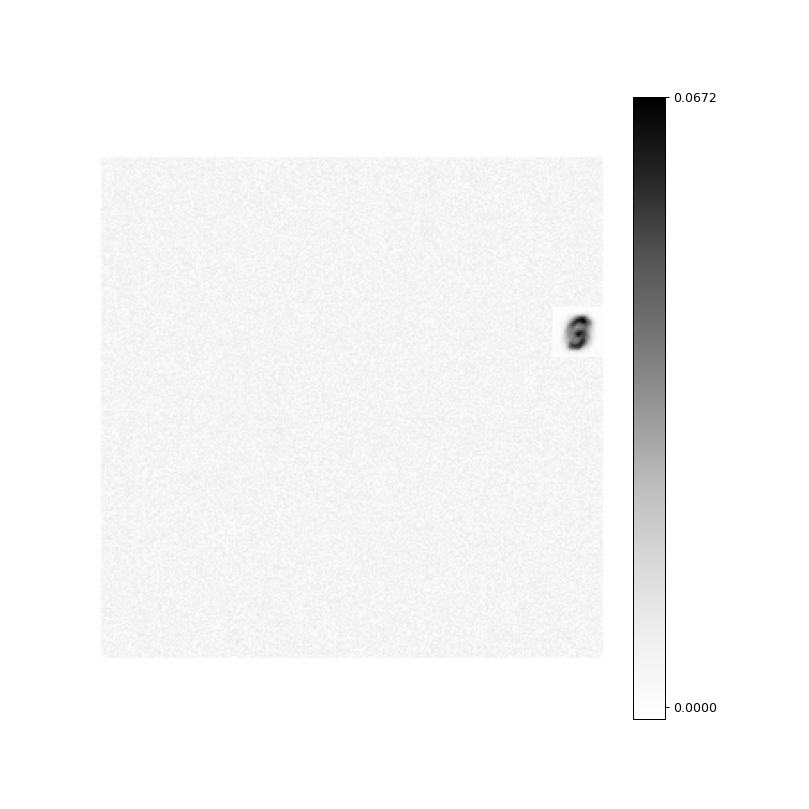

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:08<00:00, 738.88it/s]


In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 6000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28 
tr_len = 60000

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
w /= np.linalg.norm(w, axis=1).reshape(-1, 1)

# Lateral
s = np.random.uniform(-1, 1, (N, N))
s /= np.linalg.norm(s, axis=1).reshape(-1, 1)

# Bias
b = np.zeros((N, 1))

# Learning constant
xi = 0.0001

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        h = relu(w @ v)
        a = relu(s @ h + b)
        r = w.T @ a
        e = r - v
        
        del_a = np.where(a > 0, 1.0, 0.0)
        del_h = np.where(h > 0, 1.0, 0.0)
        a_tanh = 1 - np.square(np.tanh(a))
        
#         print(((w * np.sum(e.T * w, axis=1).reshape(-1, 1)) + a_tanh).shape)
#         print("yay")
        s += -h.T * del_a * ((2 * np.sum(e.T * w, axis=1).reshape(-1, 1)) + a_tanh) * xi
        
#         print("yote")
        w += -((2 * e.T * a) + (np.sum(a_tanh * del_a * s, axis=0).reshape(-1, 1) * v.T * del_h) +
               4 * ((np.sum(np.square(w), axis=1).reshape(-1, 1) * w))) * xi
        
#         print('yeat')
        b += -(2 * np.sum(e.T * w, axis=1).reshape(-1, 1) + a_tanh) * del_a * xi
        
#         print(s)
#         print(w)
#         print(b)
    draw_weights(w, Kx, Ky, 28, fig)

# Analysis Dialog

Yikes.  I'm not sure what's happening there.  Maybe the sparsity term is having too great of an effect?

I'm going to play a bit with this, and see if I can get it to behave.

<IPython.core.display.Javascript object>


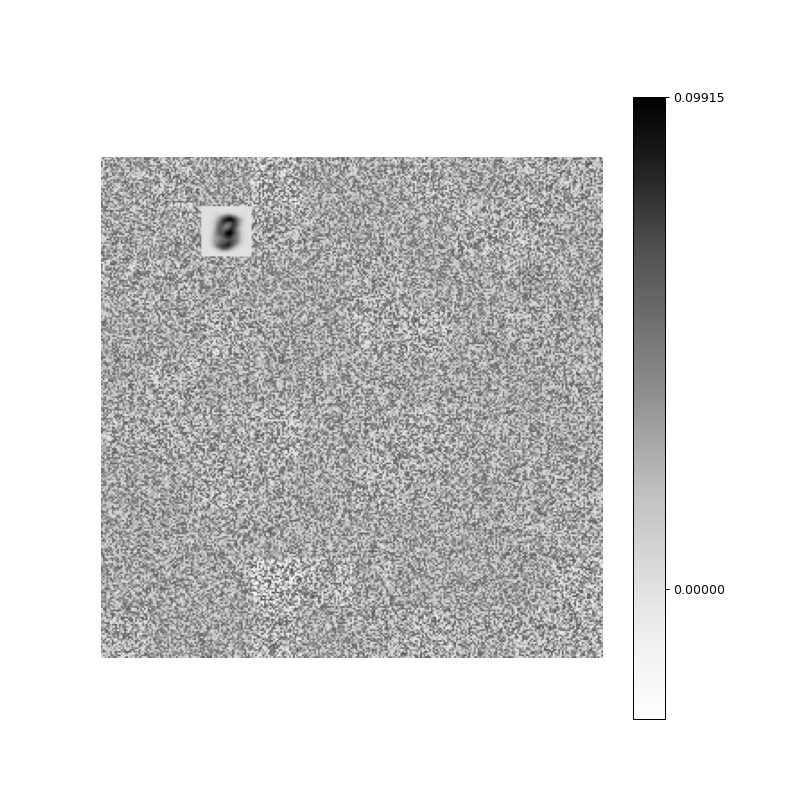

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 614.41it/s]


In [28]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 1000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28 
tr_len = 60000

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
w /= np.linalg.norm(w, axis=1).reshape(-1, 1)

# Lateral
s = np.random.uniform(-1, 1, (N, N))
s /= np.linalg.norm(s, axis=1).reshape(-1, 1)

# Bias
b = np.zeros((N, 1))

# Learning constant
xi = 0.0001
gamma = 0.01

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        h = relu(w @ v)
        a = relu((s @ h) + b)
        r = w.T @ a
        e = r - v
        
        del_a = np.where(a > 0, 1.0, 0.0)
        del_h = np.where(h > 0, 1.0, 0.0)
        a_tanh = 1 - np.square(np.tanh(a))
        
        s += -h.T * del_a * ((2 * np.sum(e.T * w, axis=1).reshape(-1, 1)) + a_tanh) * xi
        
        w += -((2 * e.T * a) + (np.sum(a_tanh * del_a * s, axis=0).reshape(-1, 1) * v.T * del_h) +
               4 * ((np.sum(np.square(w), axis=1).reshape(-1, 1) * w))) * xi
        
        w /= np.linalg.norm(w, axis=1).reshape(-1, 1)
        
        b += -(2 * np.sum(e.T * w, axis=1).reshape(-1, 1) + a_tanh) * del_a * gamma
        
    draw_weights(w, Kx, Ky, 28, fig)

Ok, there's some really weird juju afoot with this network.  I think I probably messed something up with the gradients.  I'm going to workout, and then I'm going to think about what to do.

Ok, actually, I'm going to abandon this for right now, just cause I really don't want to debug it, but I might open this up again in the future.

## Conclusions

Given how poorly this is doing, I probably messed something up in my calculation of gradients.  That being said, I really don't want to debug it, and I think I'm going to work on some more transparent architectures.

## Next steps

This is pretty unrelated, but I think I'm going to go back to the drawing board a bit.  I think I'm going to implement the Krotov Hopfield network, but with multiple winners this time to promote sparsity.  
